In [2]:
import numpy as np
import pandas as pd
from joblib import dump, load
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import itertools

In [3]:
def shuffle_arrays(arr1, arr2):
    assert len(arr1) == len(arr2)
    permutation = np.random.permutation(len(arr1))
    return arr1[permutation], arr2[permutation]

# Testing Dataset

In [4]:
df = pd.read_csv("../files/data/FINAL_CSV/SURFACE_CRACK_TEST.csv")
df

,c_index,a/c,a/t,c/b,phi,K-T
0,0.0,1.425,0.225,0.0125,0.104720,19.597453
1,0.0,1.425,0.225,0.0125,0.127808,19.453829
2,0.0,1.425,0.225,0.0125,0.150895,19.312760
3,0.0,1.425,0.225,0.0125,0.173983,19.176130
4,0.0,1.425,0.225,0.0125,0.197071,19.044489
...,...,...,...,...,...,...
56059,437.0,0.425,0.825,0.4500,2.944522,63.939989
56060,437.0,0.425,0.825,0.4500,2.967609,64.259458
56061,437.0,0.425,0.825,0.4500,2.990697,64.674951
56062,437.0,0.425,0.825,0.4500,3.013785,65.205603


In [5]:
# Get unique combinations of the first four columns
SC_test_combinations = df.iloc[:, 1:4].drop_duplicates().to_numpy()

print(len(SC_test_combinations))

print("Different a/c values: ", np.unique(SC_test_combinations[:,0], axis=0))
print("Different a/t values: ", np.unique(SC_test_combinations[:,1], axis=0))
print("Different c/b values: ", np.unique(SC_test_combinations[:,2], axis=0))

438
Different a/c values:  [0.225 0.425 0.625 0.825 1.    1.025 1.225 1.425 1.625 1.815 2.025]
Different a/t values:  [0.225 0.325 0.425 0.525 0.625 0.725 0.825]
Different c/b values:  [0.0125 0.015  0.15   0.175  0.25   0.275  0.35   0.375  0.45  ]


In [6]:
phi_values = df.iloc[:, 4].drop_duplicates().to_numpy()
print(phi_values)
print(len(phi_values))

[0.10471976 0.12780758 0.1508954  0.17398322 0.19707104 0.22015886
 0.24324668 0.2663345  0.28942232 0.31251014 0.33559796 0.35868578
 0.3817736  0.40486142 0.42794924 0.45103706 0.47412488 0.4972127
 0.52030052 0.54338834 0.56647616 0.58956398 0.6126518  0.63573962
 0.65882744 0.68191526 0.70500308 0.7280909  0.75117872 0.77426654
 0.79735436 0.82044218 0.84353    0.86661782 0.88970564 0.91279346
 0.93588128 0.9589691  0.98205692 1.00514474 1.02823256 1.05132038
 1.0744082  1.09749602 1.12058384 1.14367166 1.16675948 1.1898473
 1.21293512 1.23602294 1.25911076 1.28219858 1.3052864  1.32837422
 1.35146204 1.37454986 1.39763768 1.4207255  1.44381332 1.46690114
 1.48998896 1.51307678 1.5361646  1.55925242 1.58234024 1.60542806
 1.62851588 1.6516037  1.67469152 1.69777934 1.72086716 1.74395498
 1.7670428  1.79013062 1.81321844 1.83630626 1.85939408 1.8824819
 1.90556972 1.92865754 1.95174536 1.97483318 1.997921   2.02100882
 2.04409664 2.06718446 2.09027228 2.1133601  2.13644792 2.1595357

In [7]:
d = df.to_numpy()[:,1:]
d.shape

(56064, 5)

# RFR

In [9]:
X_test = d[:,:-1]

rfr = load('../files/trained_models/SURFACE_CRACK/rfr.joblib')
y_pred_rfr = rfr.predict(X_test)

# SVR

In [11]:
X_test = d[:,:-1]

svr = load('../files/trained_models/SURFACE_CRACK/svr.joblib')
y_pred_svr = svr.predict(X_test)

# NN

In [13]:
import src.nn as custom_nn

device = 'cuda'

In [14]:
X_test = d[:,:-1]
X_test_gpu = torch.FloatTensor(X_test).to(device)

net = custom_nn.Net10(X_test_gpu.shape[1], 100).to(device)
FILENAME = "../files/trained_models/SURFACE_CRACK/nn10.pt"
net.load_state_dict(torch.load(FILENAME, weights_only=False))

with torch.no_grad():
    y_pred_nn = net.forward(X_test_gpu).cpu().numpy()[:,0]

# DeepONet

In [15]:
from src.deeponet import DeepONet

In [16]:
X_deeponet = np.zeros((len(SC_test_combinations), 3))
phi_deeponet = np.zeros((128, 1))
y_deeponet = np.zeros((len(SC_test_combinations), 128))

for (i,combination) in enumerate(SC_test_combinations):
    indices = np.where((d[:, 0] == combination[0]) & 
                    (d[:, 1] == combination[1]) &
                    (d[:, 2] == combination[2])) 
    indices = indices[0]

    X_deeponet[i,0] = combination[0]
    X_deeponet[i,1] = combination[1]
    X_deeponet[i,2] = combination[2]

    if i == 0:
        phi_deeponet = d[indices][:,-2]
    else:
        assert (phi_deeponet[:] == d[indices][:,-2]).all()

    y_deeponet[i,:] = d[indices][:,-1]

In [17]:
device = 'cuda'

X_test_gpu = torch.FloatTensor(X_deeponet).to(device)

y_test_gpu = torch.FloatTensor(y_deeponet).to(device)

phi_gpu = torch.FloatTensor(np.expand_dims(phi_deeponet, axis=-1)).to(device)

branch_layers = [X_test_gpu.shape[1]] + [100, 100, 100, 100, 100, 100, 100, 100, 100]
trunk_layers = [1] + [100, 100, 100, 100, 100, 100, 100, 100, 100]

EPOCHS = 250000
lr = 1e-4

model_loaded = DeepONet(branch_layers, trunk_layers, 128, device, True, 
                        "../files/trained_models/SURFACE_CRACK/branch_deeponet.pt", "../files/trained_models/SURFACE_CRACK/trunk_deeponet.pt")

with torch.no_grad():
    y_pred_deeponet = model_loaded.forward(X_test_gpu, phi_gpu)

# FNO

In [21]:
from src.fno import FNO1d

modes = 64
width = 64

device = 'cuda'

In [19]:
X_fno = np.zeros((len(SC_test_combinations), 128, 4))
y_fno = np.zeros((len(SC_test_combinations), 128))

for (i, combination) in enumerate(SC_test_combinations):
    indices = np.where((d[:, 0] == combination[0]) & 
                    (d[:, 1] == combination[1]) &
                    (d[:, 2] == combination[2])) 
    indices = indices[0]

    assert (phi_values == d[indices][:,-2]).all()
    
    X_fno[i,:,:-1] = combination
    X_fno[i,:,-1] = phi_values

    y_fno[i,:] = d[indices][:,-1]

In [22]:
X_test_gpu = torch.FloatTensor(X_fno).to(device)

y_test_gpu = torch.FloatTensor(y_fno).to(device)

fno_loaded_model = FNO1d(len(phi_values), X_test_gpu.shape[-1], modes, width).to(device)
if device == "cpu":
    fno_loaded_model.load_state_dict(torch.load("../files/trained_models/SURFACE_CRACK/fno_sc.pt", map_location=torch.device('cpu'), weights_only=False))
else:
    fno_loaded_model.load_state_dict(torch.load("../files/trained_models/SURFACE_CRACK/fno_sc.pt",weights_only=False))
with torch.no_grad():
    y_pred_fno = fno_loaded_model(X_test_gpu)

# POD-DeepONet

In [23]:
from src.pod_deeponet import POD_DeepONet

branch_layers = [SC_test_combinations.shape[1]] + [128, 128, 128]
K = 128
device = 'cuda'

In [24]:
X_deeponet = np.zeros((len(SC_test_combinations), 3))
y_deeponet = np.zeros((len(SC_test_combinations), 128))

for (i,combination) in enumerate(SC_test_combinations):
    indices = np.where((d[:, 0] == combination[0]) & 
                    (d[:, 1] == combination[1]) &
                    (d[:, 2] == combination[2])) 
    indices = indices[0]

    X_deeponet[i,0] = combination[0]
    X_deeponet[i,1] = combination[1]
    X_deeponet[i,2] = combination[2]

    y_deeponet[i,:] = d[indices][:,-1]

In [25]:
y_train_pod = np.load("../files/trained_models/SURFACE_CRACK/y_train.npy")
y_train_gpu = torch.FloatTensor(y_train_pod).to(device)

X_test_gpu = torch.FloatTensor(X_deeponet).to(device)

y_test_gpu = torch.FloatTensor(y_deeponet).to(device)

model_loaded = POD_DeepONet(y_train_gpu, branch_layers, K, device, 
                        True, "../files/trained_models/SURFACE_CRACK/pod_branch_sc.pt")

with torch.no_grad():
    y_pred_pod = model_loaded.forward(X_test_gpu)

# Results

In [26]:
def absolute_perctentage_error(y_true, y_pred):
    return np.abs((y_true -  y_pred) / y_true)

def perctentage_error(y_true, y_pred):
    return (y_true -  y_pred) / y_true

def mean_normalized_l2(y_true, y_pred):
    return np.mean(np.linalg.norm(y_true -  y_pred, ord=2, axis=1) / np.linalg.norm(y_true, ord=2, axis=1))

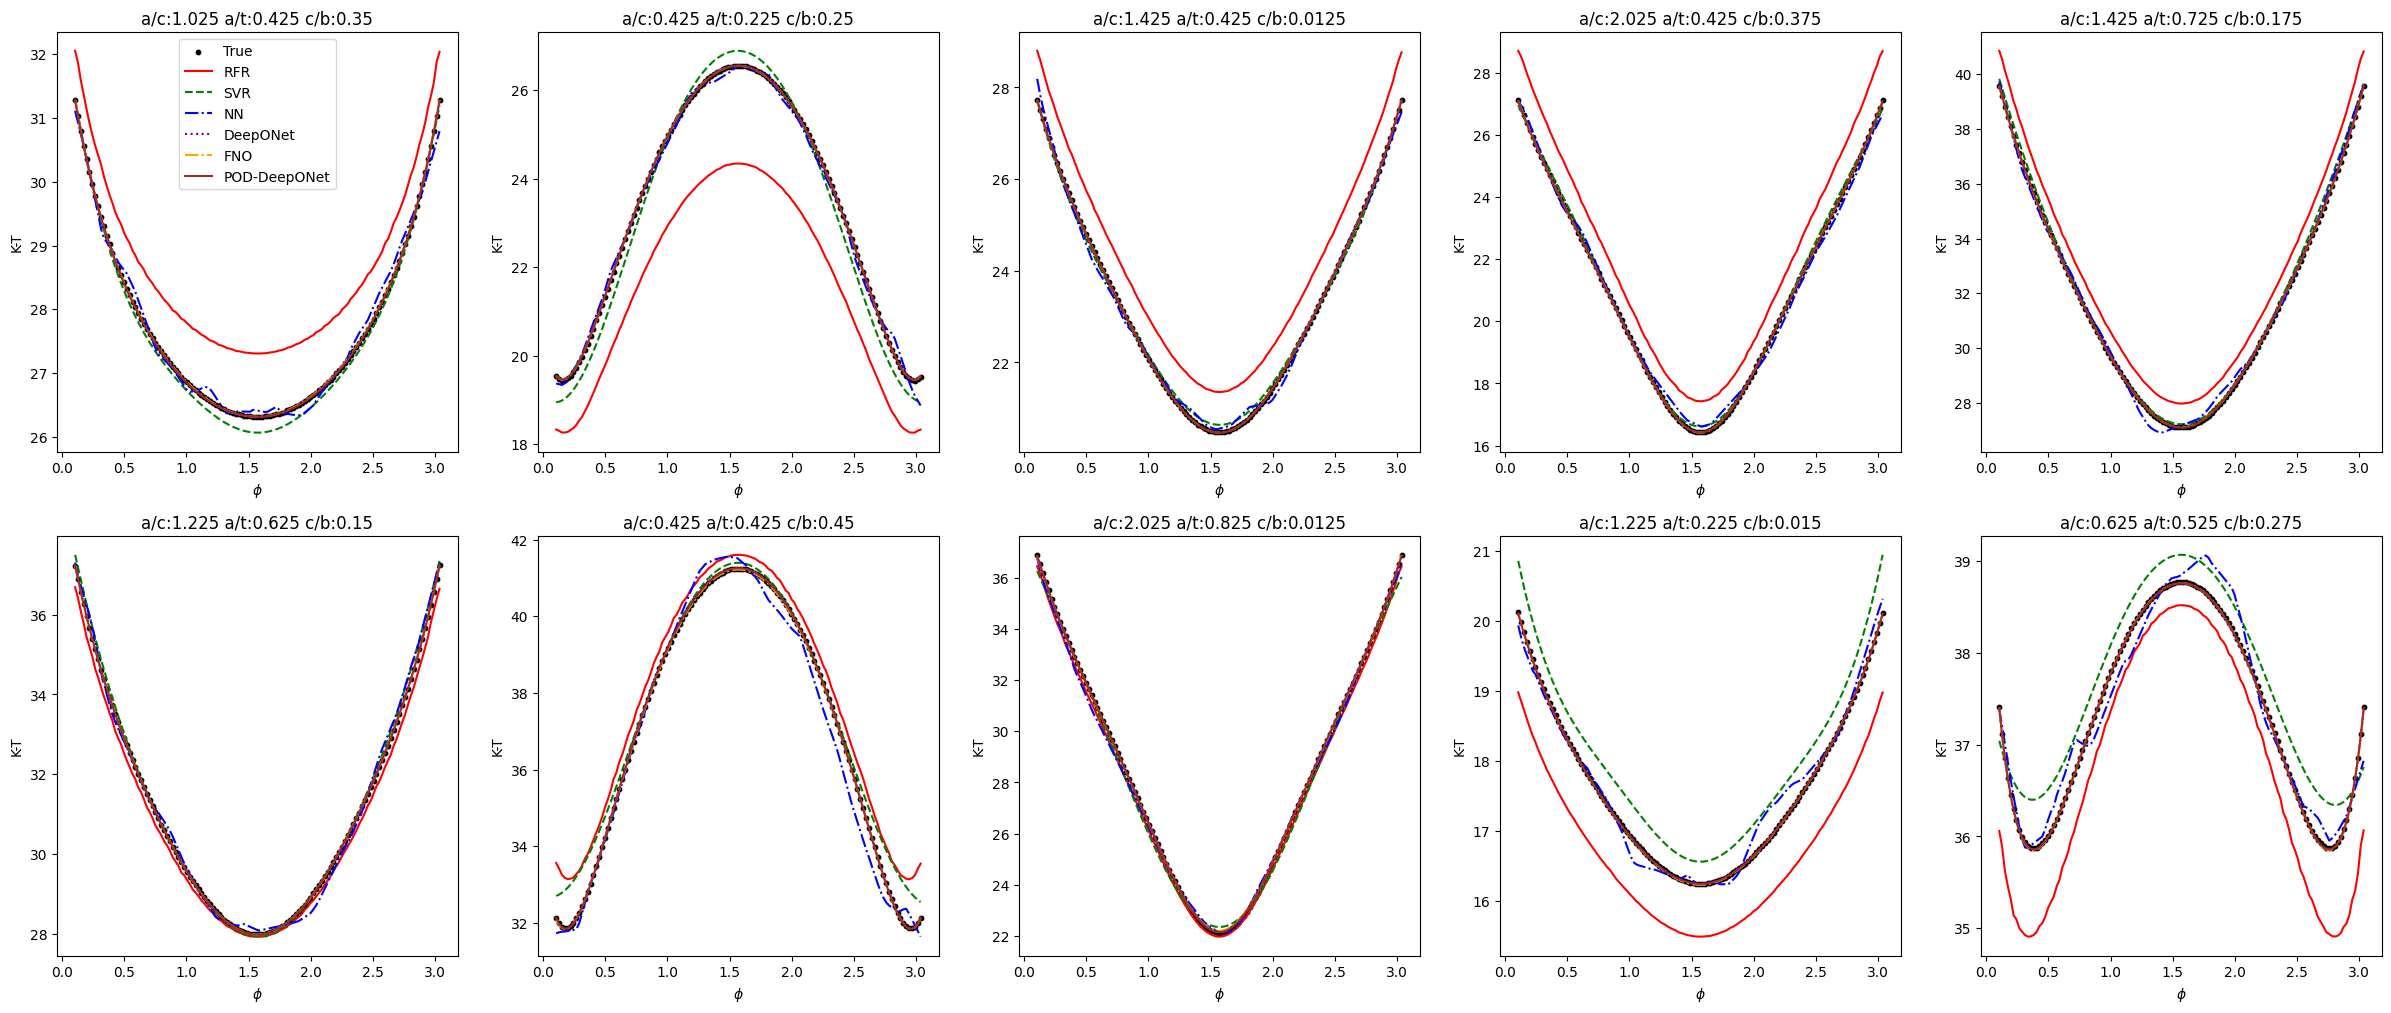

In [27]:
import matplotlib.pyplot as plt
np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(30,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(SC_test_combinations))
        a_c = SC_test_combinations[idx][0]
        a_t = SC_test_combinations[idx][1]
        c_b = SC_test_combinations[idx][2]

        indices = np.where((d[:, 0] == a_c) & 
                    (d[:, 1] == a_t) &
                    (d[:, 2] == c_b)) 
        indices = indices[0]

        axs[i,j].scatter(d[indices][:,-2], d[indices][:,-1], color='black', s=10, label="True")
        axs[i,j].plot(phi_values, y_pred_rfr[idx*128:idx*128+128], label="RFR", color='red', linestyle="-")
        axs[i,j].plot(phi_values, y_pred_svr[idx*128:idx*128+128], label="SVR", color='green', linestyle="--")
        axs[i,j].plot(phi_values, y_pred_nn[idx*128:idx*128+128], label="NN", color='blue', linestyle="-.")
        axs[i,j].plot(phi_values, y_pred_deeponet[idx].cpu(), label="DeepONet", color='purple', linestyle=":")
        axs[i,j].plot(phi_values, y_pred_fno[idx].cpu(), label="FNO", color='orange', linestyle="dashdot")
        axs[i,j].plot(phi_values, y_pred_pod[idx].cpu(), label="POD-DeepONet", color='brown', linestyle="solid")
        

        axs[i,j].set_title("a/c:{} a/t:{} c/b:{}".format(a_c, a_t, c_b))
        axs[i,j].set_ylabel("K-T")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

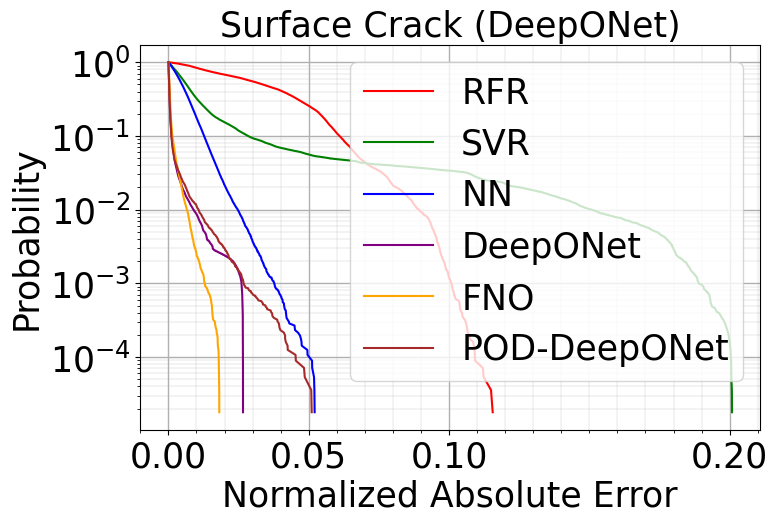

In [30]:
rfr_err_test = absolute_perctentage_error(d[:,-1], y_pred_rfr)
rfr_err_test = rfr_err_test.reshape(-1)

svr_err_test = absolute_perctentage_error(d[:,-1], y_pred_svr)
svr_err_test = svr_err_test.reshape(-1)

nn_err_test = absolute_perctentage_error(d[:,-1], y_pred_nn)
nn_err_test = nn_err_test.reshape(-1)

deeponet_err_test = absolute_perctentage_error(y_deeponet, y_pred_deeponet.cpu().numpy())
deeponet_err_test = deeponet_err_test.reshape(-1)

fno_err_test = absolute_perctentage_error(y_fno, y_pred_fno.cpu().numpy()[:,:,0])
fno_err_test = fno_err_test.reshape(-1)

pod_err_test = absolute_perctentage_error(y_deeponet, y_pred_pod.cpu().numpy())
pod_err_test = pod_err_test.reshape(-1)

plt.rcParams["figure.figsize"] = (8,5)

x = np.sort(rfr_err_test) 
y = np.arange(len(rfr_err_test)) / float(len(rfr_err_test)) 
plt.plot(x,1-y, color='red', label="RFR")

x = np.sort(svr_err_test) 
y = np.arange(len(svr_err_test)) / float(len(svr_err_test)) 
plt.plot(x,1-y, color='green', label="SVR")

x = np.sort(nn_err_test) 
y = np.arange(len(nn_err_test)) / float(len(nn_err_test)) 
plt.plot(x,1-y, color='blue', label="NN")

x = np.sort(deeponet_err_test) 
y = np.arange(len(deeponet_err_test)) / float(len(deeponet_err_test)) 
plt.plot(x,1-y, color='purple', label="DeepONet")

x = np.sort(fno_err_test) 
y = np.arange(len(fno_err_test)) / float(len(fno_err_test)) 
plt.plot(x,1-y, color='orange', label="FNO")

x = np.sort(pod_err_test) 
y = np.arange(len(pod_err_test)) / float(len(pod_err_test)) 
plt.plot(x,1-y, color='brown', label="POD-DeepONet")

plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.2)
plt.minorticks_on()
plt.xlabel("Normalized Absolute Error", fontsize=25)
plt.ylabel("Probability", fontsize=25)
plt.semilogy()
plt.xticks([0, 0.05, 0.1, 0.2], fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.title("Surface Crack (DeepONet)", fontsize=25)
plt.show()

In [31]:
rfr_l2_test = mean_normalized_l2(d[:,-1].reshape(len(SC_test_combinations), 128), y_pred_rfr.reshape(len(SC_test_combinations), 128))

svr_l2_test = mean_normalized_l2(d[:,-1].reshape(len(SC_test_combinations), 128), y_pred_svr.reshape(len(SC_test_combinations), 128))

nn_l2_test = mean_normalized_l2(d[:,-1].reshape(len(SC_test_combinations), 128), y_pred_nn.reshape(len(SC_test_combinations), 128))

deeponet_l2_test = mean_normalized_l2(y_deeponet, y_pred_deeponet.cpu().numpy())

fno_l2_test = mean_normalized_l2(y_fno, y_pred_fno.cpu().numpy()[:,:,0])

pod_l2_test = mean_normalized_l2(y_deeponet, y_pred_pod.cpu().numpy())

print("RFR: ", rfr_l2_test)
print("SVR: ", svr_l2_test)
print("NN: ", nn_l2_test)
print("DeepONet: ", deeponet_l2_test)
print("FNO: ", fno_l2_test)
print("POD-DeepONet: ", pod_l2_test)

RFR:  0.03527637489326989
SVR:  0.01631950252520879
NN:  0.007407166065611726
DeepONet:  0.0007323326303075431
FNO:  0.0007785272970786353
POD-DeepONet:  0.0007655924634752031
